# Creating Customer Segments
## Unsupervised Learning
## John Kinstler 04/21/17
### Project Files at https://github.com/m00nd00r/Customer-Segments

The dataset can be found  [here](http://mlr.cs.umass.edu/ml/datasets/Wholesale+customers), which is provided by the UCI Machine Learning Repository.

Install

This project requires Python 2.7 using the Anaconda distribution and requires packages:

    NumPy
    Pandas
    matplotlib
    scikit-learn
    seaborn

You will also need to have software installed to run and execute a Jupyter Notebook

If you do not have Python installed yet, it is highly recommended that you install the Anaconda distribution of Python, which already has the above packages and more included. Make sure that you select the Python 2.7 installer and not the Python 3.x installer.

## Getting Started

In this project, I will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, I will begin exploring the data through visualizations and code to understand how each feature is related to the others. I will show a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset to track through the course of this project.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


I also want to have a quick look at the frequency counts of the data just to get a sense of the distributions.

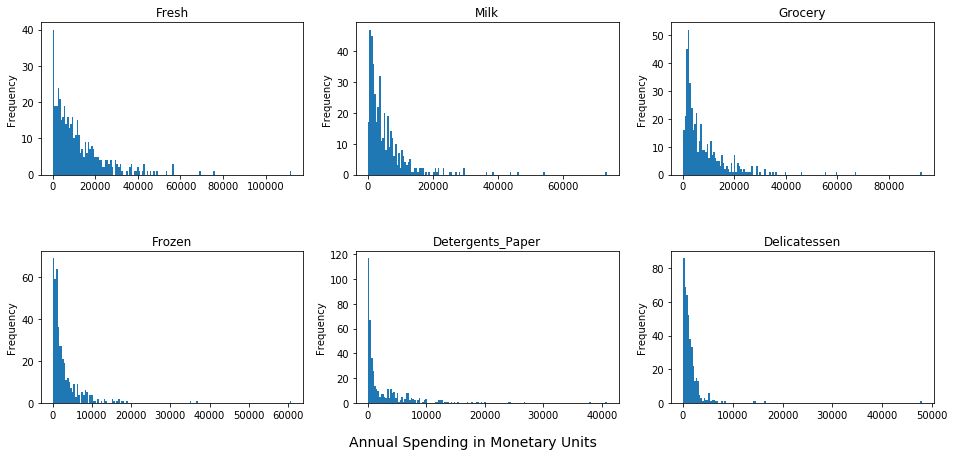

In [3]:
f, axs = plt.subplots(2,3)

plt.subplots_adjust(hspace=0.5)
f.text(0.5, 0.04, 'Annual Spending in Monetary Units', ha='center', fontsize=14)

for i in range(0,6):
    axs.flatten()[i].set_title(data.columns[i])
    data[data.columns[i]].plot(ax=axs.flatten()[i],kind = 'hist', bins=150, figsize=(16,7))

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. I also want to compare these samples to the summary statistics of the full dataset as well as have a look at a heatmap of the samples to compare their spending to the overall spending in that category.

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6137,5360,8040,129,3084,1603
1,53205,4959,7336,3012,967,818
2,161,7460,24773,617,11783,2410


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


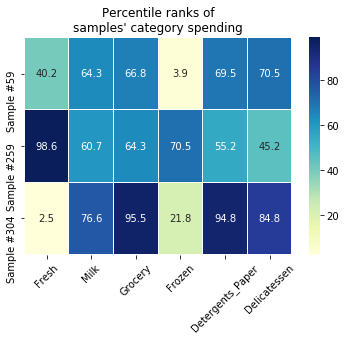

In [4]:
# Select three indices to sample from the dataset
indices = [59, 259, 304]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

# compare to overall dataset
display(data.describe())

# can also visualize those numbers with a heatmap
pcts = 100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)
#print pcts

# visualize percentiles with heatmap
sns.heatmap(pcts, yticklabels=['Sample #'+str(x) for x in indices], annot=True, linewidth=.1, vmax=99, fmt='.1f', cmap='YlGnBu')
plt.title('Percentile ranks of\nsamples\' category spending')
plt.xticks(rotation=45, ha='center');

### Observation 1
Considering the total purchase cost of each product category and the statistical description of the dataset above for your sample customers, what kind of establishment (customer) could each of the three samples I've chosen represent?  

- The first data point comes from the Retail channel from the Other Regions. This sample is very close to the mean for Milk, Grocery, Detergents_Paper, and Delicatessen; in fact in the lower part of the 3rd quartile for each. It has relatively low spending in Fresh and Frozen as the values are significantly below the mean in these. I would guess that this sample is a grocery store since grocery do carry quite a lot of milk, groceries, deli foods as well as household cleaning items.

- The second data point comes from the HoReCa channel from the Lisbon Region. This sample has spending in Fresh that is significantly higher than the mean, with Milk, Grocery, and Frozen very close to the mean and Detergents_Paper and Delicatessen significantly lower than the mean. The high spending in unprepared food items suggest to me that this would likely be a restaurant.

- The third data point comes from the Retail channel from the Oporto Region. This sample has spending in Grocery and Detergents_Paper significantly higher than the mean with above average spending in Milk and Delicatessen and significantly lower spending in Fresh and Frozen. I would guess that this is a market that sells mostly prepared foods.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [5]:
from sklearn import model_selection as cv
from sklearn.tree import DecisionTreeRegressor as dtr

# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
for i in range(len(data.columns)):
    new_data = data.drop(data.columns[i],1)

# Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = cv.train_test_split(new_data, data[data.columns[i]], test_size=0.25, random_state=1)

# Create a decision tree regressor and fit it to the training set
    regressor = dtr(random_state=1)
    clf = regressor.fit(X_train,y_train)

# Report the score of the prediction using the testing set
    score = clf.score(X_test,y_test)
    print(data.columns[i], score)

('Fresh', -0.92337365929784365)
('Milk', 0.51584994380666171)
('Grocery', 0.79576831157619576)
('Frozen', -0.64957432733365517)
('Detergents_Paper', 0.8152412791948308)
('Delicatessen', -0.42912519565854512)


### Observation 2
So, here we can see what happens when I remove each column of data in turn to how well our predictor will work. If I remove the `Fresh` column of data, my predictor yields an `R^2` score of `-0.92`. This means that without the `Fresh` data my predictor does a terrible job of predicting anything at all.

Therefore, a bit counter-intuitively, the lower the `R^2` score for this exercise, the more important that particular data is to the predictor to make useful predictions.

Based on this, you can see that Frozen and Delicatessen are also have predictive value as well.

Alternatively, you can see that removing Grocery and Detergents_Paper from the dataset would greatly increase the performance of the predictor because removing them yields very high `R^2` scores. In fact, just removing Detergents_Paper alone yields a fairly good result by itself.

### Visualize Feature Distributions
To get a better understanding of the dataset, I will construct a scatter matrix of each of the six product features present in the data. If I had found that the feature I attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if I believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

C:\Users\Johnnysporto\Anaconda2\envs\segments\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


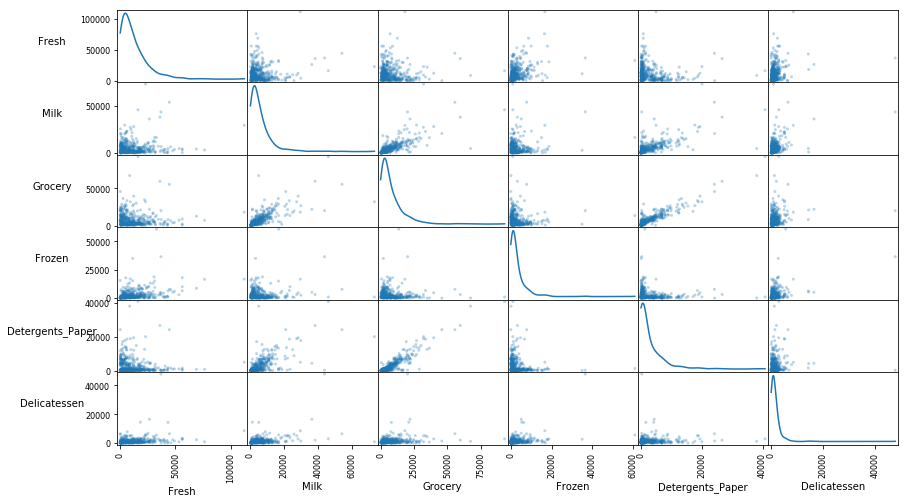

In [6]:
# Produce a scatter matrix for each pair of features in the data
ax = pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
[s.yaxis.label.set_rotation(0) for s in ax.reshape(-1)];
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in ax.reshape(-1)];

### Observation 3
This confirms my scores above with Detergents_Paper, Grocery, and Milk showing the most correlation as the data show a strong distribution upwards to the right, indicating a relationship.

The data for all of these distributions is highly skewed away from the normal with most of the data points distributed quite closely to the origin. This analysis will benefit most from scaling and normalizing the data.

Indeed, we use another heatmap to show the explicit correlations between the various features. The higher the correlations the less predictive power that feature has.

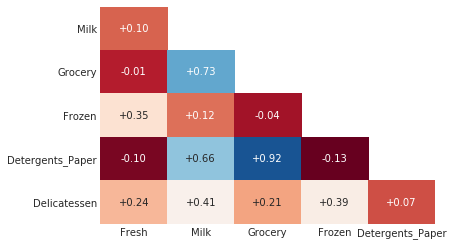

In [7]:
# get the feature correlations
corr = data.corr()

# remove first row and last column for a cleaner look
corr.drop(['Fresh'], axis=0, inplace=True)
corr.drop(['Delicatessen'], axis=1, inplace=True)

# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

# plot the heatmap
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', fmt='+.2f', cbar=False)

## Data Preprocessing
In this section, I will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

C:\Users\Johnnysporto\Anaconda2\envs\segments\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


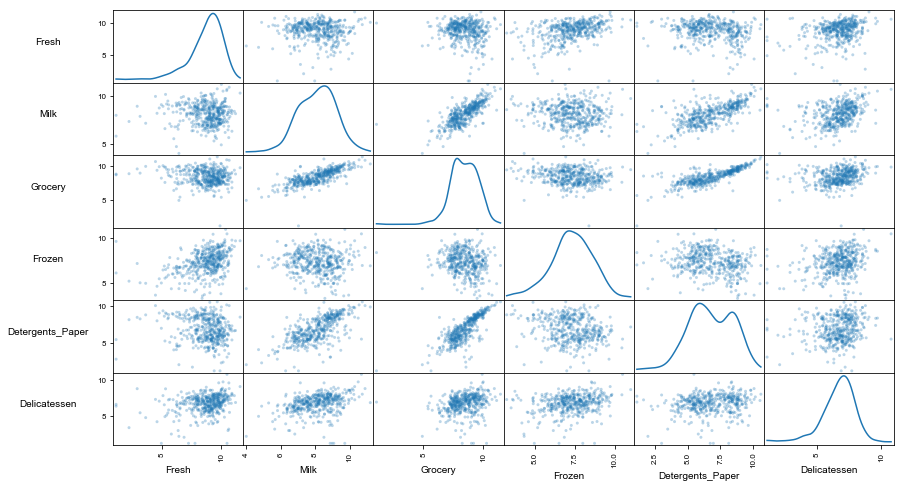

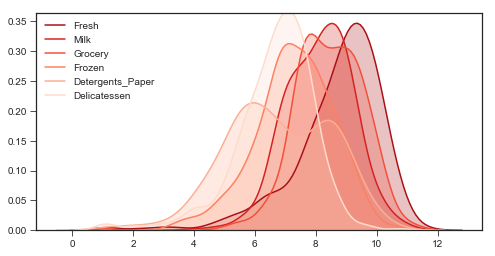

In [8]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
ax = pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
[s.yaxis.label.set_rotation(0) for s in ax.reshape(-1)];
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in ax.reshape(-1)];

# specify plot style and set color scheme
sns.set_style('ticks')
with sns.color_palette("Reds_r"):
    # plot densities of log-transformed data
    plt.figure(figsize=(8,4))
    for col in data.columns:
        sns.kdeplot(log_data[col], shade=True)
    plt.legend(loc=2);

### Observation 4
After applying a natural logarithm scaling to the data, the distribution of each feature appear much more normal. For any pairs of features identified earlier as being correlated, their correlation can now be seen more clearly.

In [9]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.722091,8.586719,8.992184,4.859812,8.033983,7.379632
1,10.881908,8.508959,8.900549,8.010360,6.874198,6.706862
2,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, I will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [10]:
from collections import defaultdict
# For each feature find the data points with extreme high or low values
#outliers = pd.DataFrame(columns=['count'])
outliers = defaultdict(int)
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# Select the indices for data points to remove
    for i in log_data.index[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]:
        outliers[i] += 1
    #outliers = outliers.append(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
        
outliers = dict(outliers)   
# Remove the outliers, if any were specified
# Remove customers that are outliers for more than 1 feature
good_data_1 = log_data.drop([k for k,v in outliers.iteritems() if v > 1]).reset_index(drop=True)
# Remove customers that are outliers for more than 2 features 
good_data_2 = log_data.drop([k for k,v in outliers.iteritems() if v > 2]).reset_index(drop=True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


In [11]:
[k for k,v in outliers.iteritems() if v > 2][0]

154

In [12]:
# I'm curious to see how many outliers there are for the different list I created above.
print("Customer data for outlier that is in 2 or more of the outlier lists")
display(data.loc[[k for k,v in outliers.iteritems() if v > 1]])

print("\nCustomer data for outlier that is in 3 of the outlier lists")
display(data.loc[[k for k,v in outliers.iteritems() if v > 2]])



Customer data for outlier that is in 2 or more of the outlier lists


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
128,140,8847,3823,142,1062,3
65,85,20959,45828,36,24231,1423
154,622,55,137,75,7,8
66,9,1534,7417,175,3468,27
75,20398,1137,3,4407,3,975



Customer data for outlier that is in 3 of the outlier lists


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
154,622,55,137,75,7,8


### Observation 5
There are a total of 42 outliers. Removing a customer for having 1 outlier in their spending seemed like it would be too cautious. However, it was easy to discover that there were 5 customers who had more than 1 outlier of their spending on items with only 1 customer having 3.

I've decided to create 2 separate datasets with all 5 removed and just the one with 3 occurences of outlier spending on items removed, so that I can see if one of them gives significantly better performance than the others.

It also appears none of my samples are in this list.

## Feature Transformation
Next, I will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

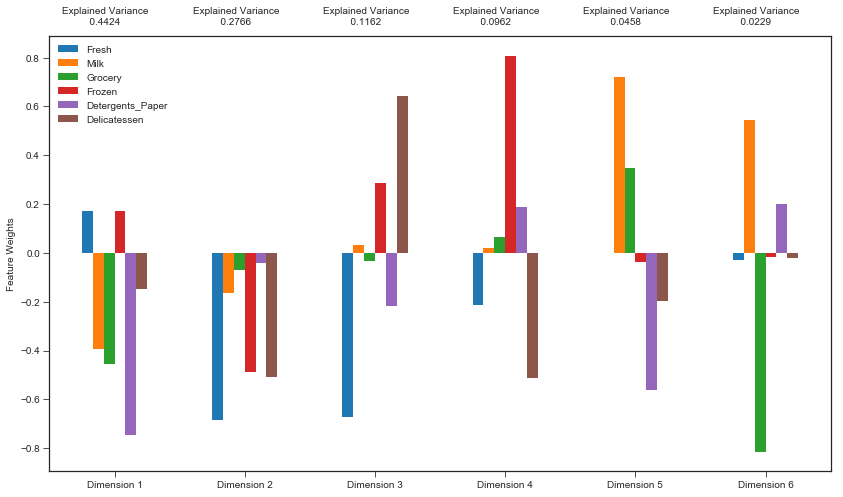

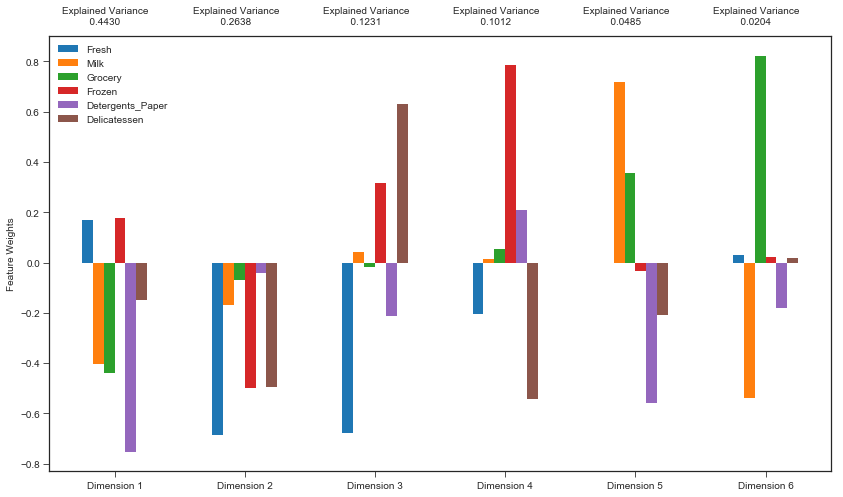

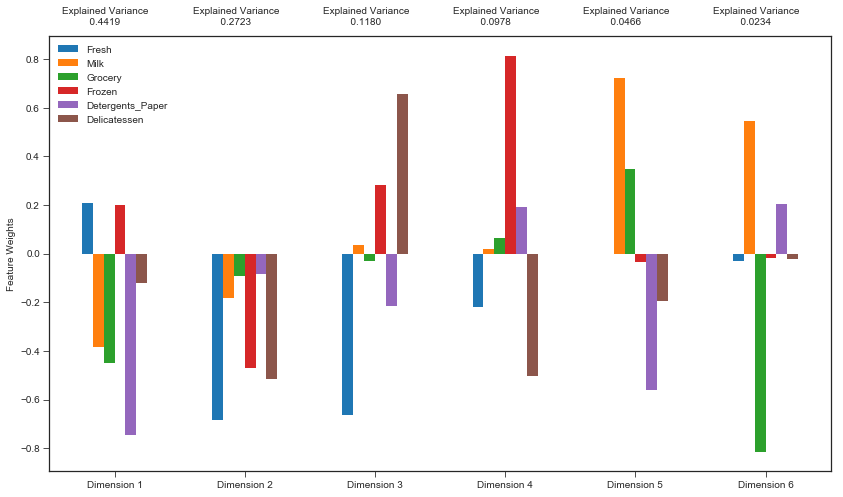

In [13]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA()
pca.fit(log_data)

pca1 = PCA()
pca1.fit(good_data_1)

pca2 = PCA()
pca2.fit(good_data_2)

# Transform the sample log-data using the PCA fit above
pca_samples = pca2.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(log_data, pca)        #no outliers removed
pca_results1 = rs.pca_results(good_data_1, pca1)   #5 outliers removed
pca_results2 = rs.pca_results(good_data_2, pca2)   #1 outlier removed


### Observation 6
A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

Here I'll analyze the last graph as it corresponds to the dataset with 1 outlier removed.

The first 2 components explain 72% of the variation. The first 4 components explain over 93% of the variation.

The 1st component shows low negative weight on Detergents_Paper, with significant negative weight on Grocery, and Milk with a very small negative weigth on Delicatessen. The postive weights here are only on Fresh and Frozen. This component might best characterize a restaurant.

The 2nd component shows negative weight for all features, with significantly low weights for Fresh, Frozen and Deli with very small effects from the rest.

The 3rd component shows high positive weight on Deli with significantly high weight on Frozen with a large negative weight on Fresh and a smaller negative weight on Detergents_Paper. This dimension might best categorize spending for cafes or small sandwich shops.

The 4th component shows high positive weight on Frozen with positive weights on Detergents_Paper, Milk, and Grocery and negative weights on Delicatessen and Fresh. This dimension might best categorize spending for small corner markets.

Below I've displayed the PCA for the samples that I've been tracking.

In [14]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.9210,0.5595,-0.4807,-2.0566,-0.2305,0.0827
1,0.1750,-1.9302,-1.2251,0.1388,0.3572,-0.2209
2,-4.0343,1.8278,2.3352,0.1392,-0.4806,-0.3109


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

C:\Users\Johnnysporto\Anaconda2\envs\segments\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead


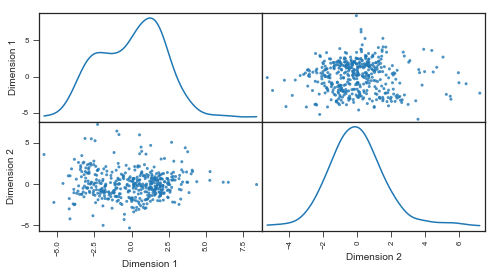

In [15]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data_2)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data_2)

# Transform the sample log-data using the PCA fit above
#samplesPCA = PCA(n_components=2)
#samplesPCA.fit(log_samples)
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# Produce a scatter matrix for pca reduced data
pd.scatter_matrix(reduced_data, alpha = 0.8, figsize = (8,4), diagonal = 'kde');

Displayed below is the same transform used above and applied to the samples.

In [16]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.9210,0.5595
1,0.1750,-1.9302
2,-4.0343,1.8278


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

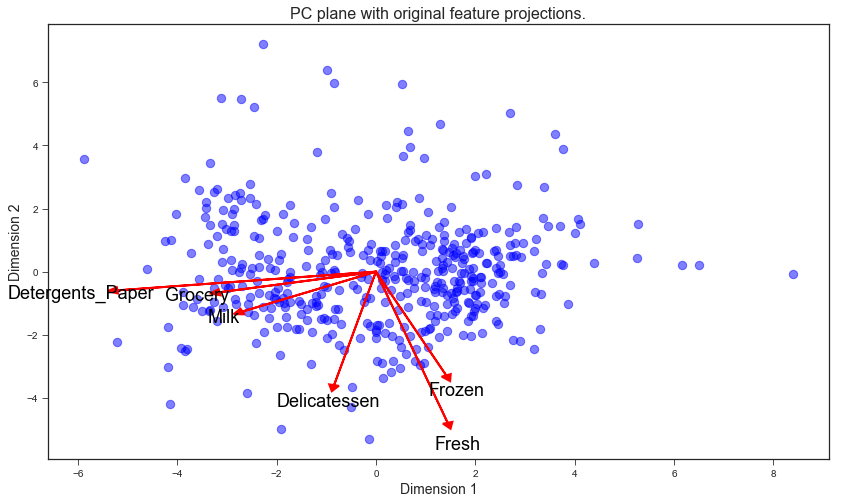

In [17]:
# Create a biplot
rs.biplot(good_data_2, reduced_data, pca)

### Observation 7

Now that I have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point in the center left area of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

You can see that Deli, Frozen and Fresh are most stongly negatively correlated in the 2nd dimension with some positive correlation in the first dimension for Frozen and Fresh.

You can also see that Detergents_Paper, Grocery, and Milk are very strongly negatively correlated in the 1s dimension with very small negative correlation in the 2nd.

## Clustering

Next, I will use a K-Means clustering algorithm to identify the various customer segments hidden in the data. I will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale.

The big advantages for K-Means is that it's fast and it converges to a definite answer. But it works best if we already have a good idea of how many clusters we're really trying to target. I'll use this to start and just run throught several clustering values and see how well it does.

GMMs might be better where K-Means seems to be too inconsistent by trying too precise and too anchored to the initialization. GMMs should be able to do a better job in this case when we can't a good score for K-Means for a particular initialization of pc components and centroid locations.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [18]:
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

# TODO: Apply your clustering algorithm of choice to the reduced data 
clustererkmeans = KMeans(n_clusters=2, init='k-means++', random_state = 3000).fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clustererkmeans.predict(reduced_data)

# TODO: Find the cluster centers
centers = clustererkmeans.cluster_centers_
labels = clustererkmeans.labels_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clustererkmeans.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, labels, metric='euclidean')
print(score);print(sample_preds)

0.422444887092
[0 1 0]


Here are several silhouette scores for the above KMeans algorithm. 2 clusters gives the best scores.

For 2 clusters: 0.419490577735  
For 3 clusters: 0.392652231899  
For 4 clusters: 0.329673296145  
For 5 clusters: 0.350392242654  
For 6 clusters: 0.351343785807

### Cluster Visualization
With the optimal number of clusters for KMeans algorithm using the scoring metric above, we can now visualize the results.

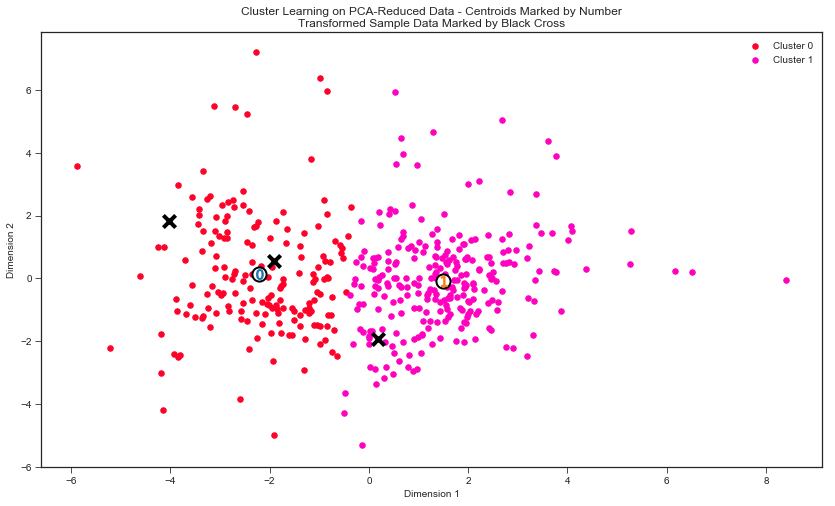

In [19]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [20]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments

# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
    
display(samples)
display(true_centers)
display(data.describe())

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6137,5360,8040,129,3084,1603
1,53205,4959,7336,3012,967,818
2,161,7460,24773,617,11783,2410


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3575.0,7761.0,12516.0,892.0,4610.0,964.0
Segment 1,9047.0,1943.0,2400.0,2113.0,296.0,695.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Observation 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

A customer assigned to Cluster 0 should best identify with establishments such as hotels, restaurants, and cafes given the high spending in Fresh, Frozen, and Deli (FFD), or foods to be prepared in house.

Cluster 1 customers are definitely grocery stores and retail stores given the high spending in Milk, Grocery, and Detergernts_Paper (MGDP).

So, according to our PCA, if samples 0 and 2 are in cluster 1, we should see high spending in MGDP, which we do. However, sample 0, does look to have not be an ideal candidate for cluster 1. It seems like it's on the threshold between the two groups.

Similarly, we should see high spending in Fresh, Frozen, and Delicatessen (FFD) for sample 1, which, again we do, although a bit low for Delicatessen.

## Conclusion

To conclude I will consider ways that we can make use of the clustered data. First, I will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, I will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, I will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Observation 9
*How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  

---
My guess here is that the MGDP segment will be far more tolerant of a decline in delivery service as their products typically have much longer shelf life and thus can afford to buy larger volumes and tolerate holding them on their shelves longer to accommodate less delivery service.

However, the customers predicted to be a part of the FFD segment buy products that are quite perishable and very likely have businesses like fresh food markets and restaurants where they have high sales of these products on a daily basis. These customers would likely be very sensitive to delivery schedules, thus I would guess that they would respond most negatively to any decline in delivery service.

Therefore, using this data analysis I would recommend that we initiate a test by selecting a sample of customers from the MGDP segment and notifying them that the company will be reducing service from 5 deliveries per week to 3. Additionally, if any of them cannot accept this reduction to contact the company to request that no reduction in service apply to them. From there we can log requests for zero interruption in service as an indication of whether it would benefit the company from proceeding with this service change to this segment.

Once completed, we can then do the same test for the FFD segment. The results of these tests should not only confirm whether our analysis was correct but also whether the company can afford to reduce services based on these segmentations.

### Observation 10
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. 

Let's assume that the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  

Since we want to predict which category the distributor's new customers would be in, we already know how to label the new customers and that the distributors database of customers is likely not greater than 100,000 customers, we can use a supervised classifier like SVC or Naive Bayes to start or maybe Decision Trees or other Ensembles to attain better results as needed.

Our target variable would be the MGDP segment and whether each new customer was a member of this category or not. If not, the customer would either be assumed to be part of the the FFD segment, or we could simply run a separate learner using the FFD segment as our target and then compare with the original to see how well our learners are doing.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.


In [21]:
outliers2 = [k for k,v in outliers.iteritems() if v > 2]


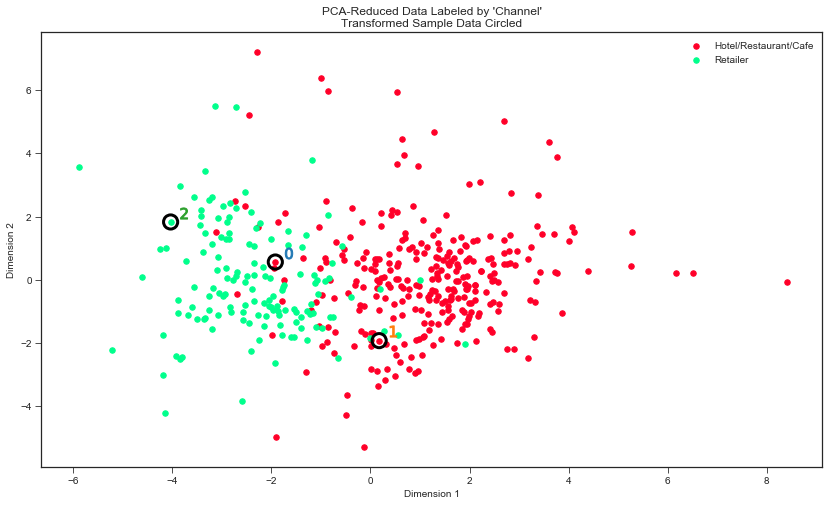

In [22]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers2, pca_samples)

### Observation 11
Interesting. Our clustering did very well in predicting the Channel feature as did our PCA in describing the 2 additional customer segments.

So, samples 0 and 2 are predicted to be a part of cluster 1 in the green on the right. This is due to it's relatively higher spending in MGDP. But clearly sample 0 is red and thus part of the HoReCa channel, which is easy to confirm in the data. However, it's position on the grid above seems to make it appear as though it ought to be within the HoReCa channel. Maybe there's somthing to do with being from the Other Regions group.

Otherwise, the other two samples are predicted correctly. Clearly there's room for further investigation.